In [1]:
import numpyro

from numpyro.distributions import constraints
from numpyro.distributions.transforms import Transform, ExpTransform
from numpyro.distributions.distribution import Distribution, TransformedDistribution

import numpyro.distributions as dist
import numpyro.infer.initialization as init

from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp

from jax import random, vmap

numpyro.set_host_device_count(10)

import numpy as np

import arviz as az

from jax import lax
from jax.scipy.special import erf, i0e, i1e, i0

from numpyro.distributions.util import (
    is_prng_key,
    promote_shapes,
    safe_normalize,
    validate_sample,
    von_mises_centered,
)

In [2]:
class Circular(constraints._Interval):
    def __init__(self):
        self.lower_bound = -jnp.pi
        self.upper_bound = jnp.pi

circular = Circular()

In [3]:
class CircularTransform(Transform):
#     domain = constraints.interval(-np.pi, np.pi)
#     codomain = constraints.interval(-np.pi, np.pi)
    codomain = circular

    def __call__(self, x):
        return jnp.arctan2(jnp.sin(x), jnp.cos(x))

    def _inverse(self, y):
        return y

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        return jnp.zeros(x.shape)

In [4]:
from numpyro.distributions.transforms import biject_to

In [5]:
@biject_to.register(circular)
def _transform_to_circular(constraint):
    return CircularTransform()

In [6]:
class VonMises(Distribution):
    arg_constraints = {"loc": constraints.real, "concentration": constraints.positive}
    reparametrized_params = ["loc"]
    support = circular

    def __init__(self, loc, concentration, validate_args=None):
        """von Mises distribution for sampling directions.
        :param loc: center of distribution
        :param concentration: concentration of distribution
        """
        self.loc, self.concentration = promote_shapes(loc, concentration)

        batch_shape = lax.broadcast_shapes(jnp.shape(concentration), jnp.shape(loc))

        super(VonMises, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )

    def sample(self, key, sample_shape=()):
        """Generate sample from von Mises distribution
        :param key: random number generator key
        :param sample_shape: shape of samples
        :return: samples from von Mises
        """
        assert is_prng_key(key)
        samples = von_mises_centered(
            key, self.concentration, sample_shape + self.shape()
        )
        samples = samples + self.loc  # VM(0, concentration) -> VM(loc,concentration)
        samples = (samples + jnp.pi) % (2.0 * jnp.pi) - jnp.pi

        return samples

    @validate_sample
    def log_prob(self, value):
#         value = circular_transform(value)
        return -(
            jnp.log(2 * jnp.pi) + jnp.log(i0e(self.concentration))
        ) + self.concentration * (jnp.cos((self.loc - value)))

    @property
    def mean(self):
        """Computes circular mean of distribution. NOTE: same as location when mapped to support [-pi, pi]"""
        return jnp.broadcast_to(
            (self.loc + jnp.pi) % (2.0 * jnp.pi) - jnp.pi, self.batch_shape
        )

    @property
    def variance(self):
        """Computes circular variance of distribution"""
        return jnp.broadcast_to(
            1.0 - i1e(self.concentration) / i0e(self.concentration), self.batch_shape
        )

In [11]:
def model():
#     base_dist = VonMises(3.0, 4.0)
#     base_dist = dist.Normal(3.0, 1.0)
#     phi = numpyro.sample('phi', dist.TransformedDistribution(base_dist, CircularTransform()))
#     phi = numpyro.sample('phi', dist.VonMises(0.0, 4.0))
    phi_old = numpyro.sample('phi_old', dist.VonMises(3.0, 4.0))
    phi_new = numpyro.sample('phi_new', VonMises(3.0, 4.0))

In [12]:
rng_key = random.PRNGKey(10)

In [13]:
num_warmup, num_samples, num_chains = 1000, 1000, 10

rng_map = random.split(rng_key, num_chains)

kernel = NUTS(model, init_strategy=init.init_to_median)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_map)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'phi_new'}>,
        <AxesSubplot:title={'center':'phi_new'}>],
       [<AxesSubplot:title={'center':'phi_old'}>,
        <AxesSubplot:title={'center':'phi_old'}>]], dtype=object)

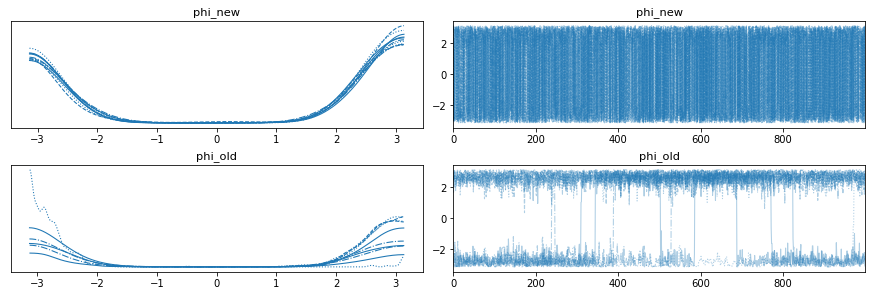

In [14]:
trace = az.from_numpyro(mcmc)

az.plot_trace(trace)

In [75]:
test_dist = VonMises(3.0, 4.0)

In [77]:
sample = test_dist.sample(rng_key, sample_shape=(1000,))

In [79]:
import matplotlib.pyplot as plt

(array([309.,  60.,   3.,   2.,   0.,   1.,   1.,  21., 146., 457.]),
 array([-3.1411884e+00, -2.5129216e+00, -1.8846546e+00, -1.2563878e+00,
        -6.2812096e-01,  1.4591217e-04,  6.2841278e-01,  1.2566797e+00,
         1.8849465e+00,  2.5132134e+00,  3.1414802e+00], dtype=float32),
 <BarContainer object of 10 artists>)

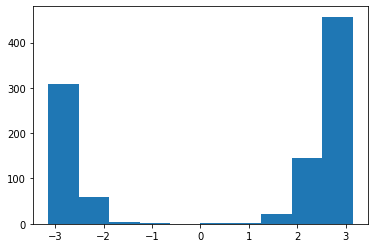

In [80]:
plt.hist(sample)

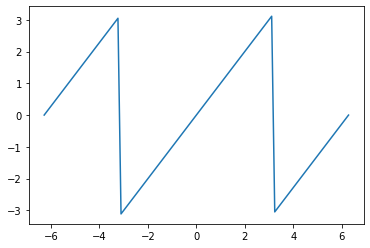

In [181]:
x = np.linspace(-2*np.pi, 2*np.pi, 100)
y = jnp.arctan2(jnp.sin(x), jnp.cos(x))

plt.plot(x, y)

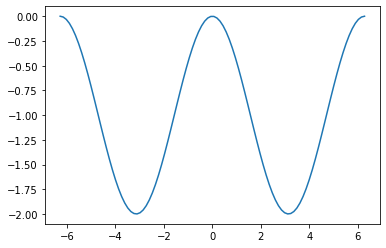

In [205]:
plt.plot(x, np.cos(x % (2 * jnp.pi)) - 1)

In [226]:
logp = - (jnp.log(2 * jnp.pi) + jnp.log(i0e(test_dist.concentration))
        ) + test_dist.concentration * (jnp.cos((x - test_dist.loc)))

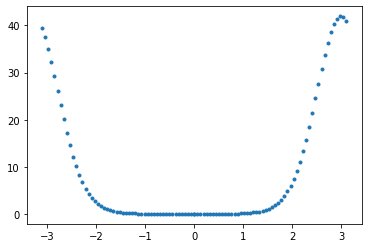

In [231]:
plt.plot(jnp.arctan2(jnp.sin(x), jnp.cos(x)), jnp.exp(logp), '.')